In [1]:
%load_ext autoreload
%autoreload 2

from aeon.datasets import load_classification
import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics import AUROC, Accuracy
import collections
import os

from models import LogisticRegressionWithSummariesAndBottleneck_Wrapper
from preprocess_helpers import *
from helper import *
from param_initializations import *
from optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [2]:
X, y, meta_data = load_classification("SpokenArabicDigits", extract_path="/workdir/data")
print(" Shape of X = ", len(X), X[0].shape)
print(" Shape of y = ", y.shape)
print(" Meta data = ", meta_data)
y = y.astype(int)
y


 Shape of X =  8798 (13, 38)
 Shape of y =  (8798,)
 Meta data =  {'problemname': 'spokenarabicdigits', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': False, 'classlabel': True, 'targetlabel': False, 'class_values': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']}


array([ 1,  1,  1, ..., 10, 10, 10])

In [3]:
lengths = []
for i, x in enumerate(X):
    lengths.append(x.shape[1])
lengths.sort()

MIN_TS_SIZE = min(lengths)
MAX_TS_SIZE = max(lengths)

print(MIN_TS_SIZE, MAX_TS_SIZE)

counter = collections.Counter(lengths)
counter


4 93


Counter({4: 1,
         7: 2,
         9: 3,
         11: 1,
         12: 2,
         13: 3,
         14: 6,
         15: 10,
         16: 6,
         17: 8,
         18: 8,
         19: 13,
         20: 13,
         21: 23,
         22: 33,
         23: 57,
         24: 67,
         25: 75,
         26: 102,
         27: 110,
         28: 113,
         29: 164,
         30: 225,
         31: 254,
         32: 297,
         33: 382,
         34: 367,
         35: 378,
         36: 403,
         37: 485,
         38: 444,
         39: 484,
         40: 431,
         41: 388,
         42: 343,
         43: 342,
         44: 353,
         45: 317,
         46: 320,
         47: 260,
         48: 223,
         49: 173,
         50: 196,
         51: 149,
         52: 114,
         53: 93,
         54: 104,
         55: 77,
         56: 82,
         57: 66,
         58: 50,
         59: 44,
         60: 33,
         61: 24,
         62: 17,
         63: 9,
         64: 11,
         65: 3,
 

In [4]:
def preprocess_data_binary(X, target):
    equi_length_X = []
    for x in X:
        pad_width = ((0, 0), (0, MAX_TS_SIZE - x.shape[1]))
        padded = np.pad(x, pad_width, mode='constant', constant_values=0)
        equi_length_X.append(padded)

    equi_length_X = np.array(equi_length_X)
    equi_length_X = equi_length_X.swapaxes(1,2)
    
    indicators_3d = ~np.isnan(equi_length_X)

    data = np.concatenate([equi_length_X, indicators_3d], axis=-1)
    
    ## target
    # convert problem to 1 vs all
    _y = np.copy(target)
    _y[_y > 1] = 0
    
    # convert y to logits
    y_logits = np.vstack([(~_y.astype(bool)).astype(int), _y])
    y_logits = np.swapaxes(y_logits, 0, 1)
    
    # weights
    pos_prop = np.mean(np.array(y_logits)[:, 1])
    p_weight = torch.Tensor([1 / (1 - pos_prop), 1 / pos_prop]).to(device)
    
    return data, y_logits, p_weight

def preprocess_data_multiclass(X, target):
    equi_length_X = []
    for x in X:
        pad_width = ((0, 0), (0, MAX_TS_SIZE - x.shape[1]))
        padded = np.pad(x, pad_width, mode='constant', constant_values=0)
        equi_length_X.append(padded)

    equi_length_X = np.array(equi_length_X)
    equi_length_X = equi_length_X.swapaxes(1,2)
    
    indicators_3d = ~np.isnan(equi_length_X)

    data = np.concatenate([equi_length_X, indicators_3d], axis=-1) # (N x ts_length x 2*changing_dim)
    
    ## target
    _y = np.copy(target)
    y_unique = np.unique(_y)
    num_classes = len(y_unique)
    
    # initiazing datasets
    weights = compute_class_weight(class_weight='balanced', classes=y_unique, y=_y)
    weights = torch.Tensor(weights).to(device)
    
    # 1 hot encode
    y_one_hot = np.eye(num_classes)[_y-1]
    
    return data, y_one_hot, num_classes, weights


In [5]:
def tensor_wrap(x, klass=torch.Tensor):
    return x if 'torch' in str(type(x)) else klass(x)

def initialize_data(r, _X, _y, batch_size = 128, multiclass = False):   
    
    # train-test-split
    torch.set_printoptions(sci_mode=False)
    X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size = 0.15, random_state = r, stratify = _y)

    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = r, stratify = y_train)

    X_train_pt = Variable(tensor_wrap(X_train))#.to(device)
    y_train_pt = Variable(tensor_wrap(y_train, torch.FloatTensor))#.to(device)

    X_val_pt = Variable(tensor_wrap(X_val))#.to(device)
    y_val_pt = Variable(tensor_wrap(y_val, torch.FloatTensor))#.to(device)

    X_test_pt = Variable(tensor_wrap(X_test))#.to(device)
    y_test_pt = Variable(tensor_wrap(y_test, torch.FloatTensor))#.to(device)
    if multiclass:
        y_test_pt = torch.argmax(y_test_pt, dim=1)

    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4, pin_memory=True)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=False, num_workers=4, pin_memory=True)

    test_dataset = TensorDataset(X_test_pt, y_test_pt)
    test_loader = DataLoader(test_dataset, batch_size = X_test_pt.shape[0], shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader


In [6]:
def initializeModel(n_concepts, input_dim, changing_dim, time_len, output_dim = 2, top_k=''):
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                changing_dim, 
                                                9,                     
                                                n_concepts,
                                                True,
                                                init_cutoffs_to_zero, 
                                                init_rand_lower_thresholds, 
                                                init_rand_upper_thresholds,
                                                cutoff_times_temperature=0.1,
                                                cutoff_times_init_values=None,
                                                time_len=time_len,
                                                opt_lr = 2e-4,
                                                opt_weight_decay = 2e-05,
                                                l1_lambda=0.001,
                                                cos_sim_lambda=0.01,
                                                output_dim = output_dim,
                                                top_k=top_k,
                                                )
    logregbottleneck = logregbottleneck.to(device)
    return logregbottleneck

In [7]:
def set_seed(r):
    torch.backends.cudnn.deterministic = True
    random.seed(r)
    torch.manual_seed(r)
    torch.cuda.manual_seed(r)
    np.random.seed(r)


In [8]:
# write results to csv
def write_row_to_csv(experiment_folder, row, filename = "gridsearch"):
    with open('{file_path}.csv'.format(file_path=os.path.join(experiment_folder, filename)), 'a+') as csvfile: 
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(row)


## Binary

In [ ]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/arabic/binary/"
model_path = experiment_folder + "arabic_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_binary = []

set_seed(random_seed)

data, y_logits, weights = preprocess_data_binary(X, y)
train_loader, val_loader, test_loader = initialize_data(1, data, y_logits)

input_dim = data.shape[2]
changing_dim = X[0].shape[0]
ts_length = data.shape[1]

auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)

for n_concepts in range(1,16):
    print("n_concepts", n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, ts_length)
    model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward_probabilities(Xb)
            
            auc = auroc_metric(preds, yb).item()
            acc = accuracy_metric(preds, yb).item()
        auc = auroc_metric.compute().item()
        acc = accuracy_metric.compute().item()
        auroc_metric.reset()
        accuracy_metric.reset()
    
    history = [n_concepts, model.val_losses[-1], auc, acc]
    history_binary.append(np.array(history))
history_binary = np.array(history_binary)
history_binary.shape


In [ ]:
# plot
plt.plot(history_binary[:, 0], history_binary[:, 2], label='AUC')
plt.plot(history_binary[:, 0], history_binary[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_binary[:, 0]), max(history_binary[:, 0])+1, 1))

for x,_y in zip(history_binary[:, 0], history_binary[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_binary[:, 0], history_binary[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend()
plt.show()


In [ ]:
# feature weights
n_concepts = 5

model = initializeModel(n_concepts, input_dim, changing_dim, ts_length)
model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
best_aucs, best_auc_inds, best_auc_concepts = greedy_selection(auroc_metric, test_loader, top_k_inds, model)


In [ ]:
filename = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Best AUC", "Best AUC Concept #", "Best AUC ind #"])
    # writing the data rows 
    for row in zip(best_aucs, best_auc_concepts, best_auc_inds):
        csvwriter.writerow(list(row))


## Multi-class

In [9]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass_fixed/"
model_path = experiment_folder + "arabic_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [11]:
history_multiclass = []

set_seed(random_seed)

data, y_ohe, num_classes, weights = preprocess_data_multiclass(X, y)
train_loader, val_loader, test_loader = initialize_data(1, data, y_ohe, multiclass=True)

input_dim = data.shape[2] * data.shape[1]
changing_dim = X[0].shape[0]
ts_length = data.shape[1]

auroc_metric = AUROC(task="multiclass", num_classes=num_classes).to(device)
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

for n_concepts in range(1,11):
    print(n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, ts_length, num_classes)
    model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)
    
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
    history = [n_concepts, model.val_losses[-1], auc, acc]
    history_multiclass.append(np.array(history))
history_multiclass = np.array(history_multiclass)
history_multiclass.shape


1


100%|██████████| 1000/1000 [08:41<00:00,  1.92it/s]


2


100%|██████████| 1000/1000 [09:28<00:00,  1.76it/s]


3


100%|██████████| 1000/1000 [09:30<00:00,  1.75it/s]


4


100%|██████████| 1000/1000 [09:28<00:00,  1.76it/s]


5


100%|██████████| 1000/1000 [09:30<00:00,  1.75it/s]


6


100%|██████████| 1000/1000 [09:29<00:00,  1.76it/s]


7


100%|██████████| 1000/1000 [09:30<00:00,  1.75it/s]


8


100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


9


100%|██████████| 1000/1000 [09:30<00:00,  1.75it/s]


10


100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


(10, 4)

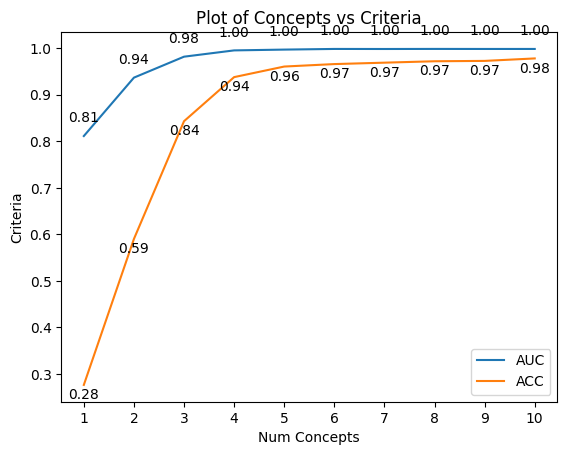

In [12]:
# plot
plt.plot(history_multiclass[:, 0], history_multiclass[:, 2], label='AUC')
plt.plot(history_multiclass[:, 0], history_multiclass[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_multiclass[:, 0]), max(history_multiclass[:, 0])+1, 1))

for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.legend()
plt.show()


In [13]:
# feature weights
n_concepts = 4

model = initializeModel(n_concepts, input_dim, changing_dim, ts_length, num_classes)
model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

Loaded model from /workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass_fixed/arabic_c4.pt


0it [00:00, ?it/s]


(4, 2574)

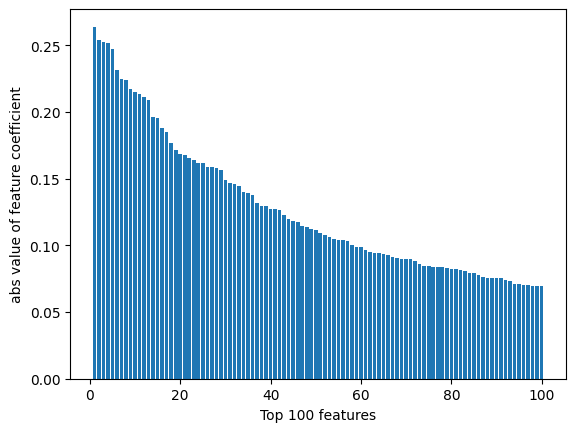

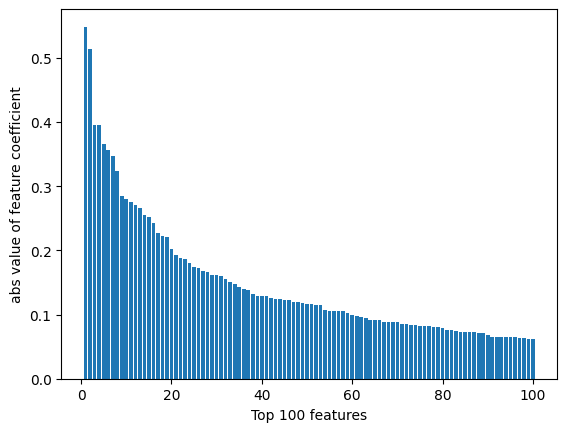

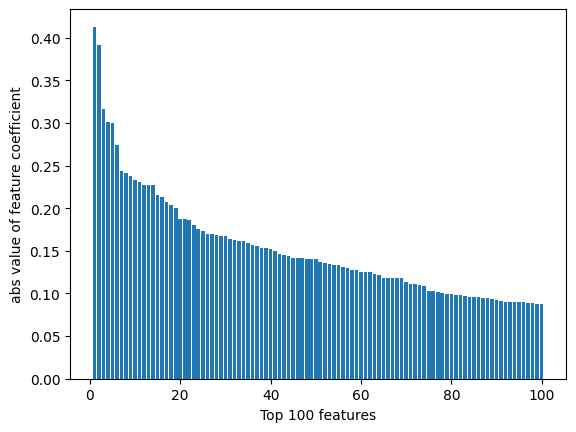

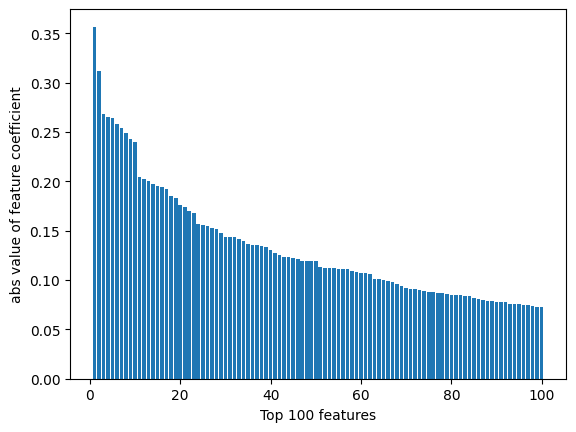

In [14]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [15]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


(4,)

In [16]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

[[109,
  3,
  32,
  262,
  686,
  894,
  184,
  966,
  836,
  914,
  291,
  818,
  7,
  712,
  1279,
  709,
  735,
  1077,
  31,
  1482,
  292,
  604,
  55,
  713,
  159,
  710,
  28,
  113,
  266,
  1255,
  369,
  526,
  9,
  289,
  241,
  319,
  556,
  739,
  468,
  838,
  996,
  501,
  214,
  236,
  732,
  2,
  83,
  657,
  52,
  211,
  947,
  660,
  655,
  423,
  918,
  1196,
  271,
  368,
  578,
  167,
  1331,
  624,
  212,
  186,
  630,
  602,
  192,
  239,
  764,
  57,
  733,
  293,
  758,
  34,
  711,
  736,
  81,
  393,
  629,
  267,
  288,
  890,
  342,
  866,
  265,
  213,
  38,
  786,
  287,
  348,
  400,
  1354,
  261,
  992,
  1201,
  787,
  371,
  522,
  888,
  810,
  761,
  134,
  340,
  89,
  295,
  812,
  58,
  60,
  157,
  323,
  1456,
  375,
  886,
  864,
  209,
  59,
  1304,
  814,
  945,
  296,
  107,
  1198,
  446,
  105,
  632,
  215,
  495,
  628,
  919,
  1300,
  631,
  528,
  366,
  163,
  759,
  991,
  395,
  344,
  56,
  374,
  424,
  1253,
  397,
  237,
  

In [17]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [31]:
V = 13 + 1
T = ts_length + 1
print(T)
vars_ = [i for i in range(1,V)] + [str(i) + "_ind" for i in range(1,V)]
print(len(vars_))
data_cols = [["feat_{}_time_{}".format(v, t) for v in vars_] for t in range(1, T)]
flattened_data_cols = [col for sublist in data_cols for col in sublist]
print(len(flattened_data_cols))
flattened_data_cols

94
26
2418


['feat_1_time_1',
 'feat_2_time_1',
 'feat_3_time_1',
 'feat_4_time_1',
 'feat_5_time_1',
 'feat_6_time_1',
 'feat_7_time_1',
 'feat_8_time_1',
 'feat_9_time_1',
 'feat_10_time_1',
 'feat_11_time_1',
 'feat_12_time_1',
 'feat_13_time_1',
 'feat_1_ind_time_1',
 'feat_2_ind_time_1',
 'feat_3_ind_time_1',
 'feat_4_ind_time_1',
 'feat_5_ind_time_1',
 'feat_6_ind_time_1',
 'feat_7_ind_time_1',
 'feat_8_ind_time_1',
 'feat_9_ind_time_1',
 'feat_10_ind_time_1',
 'feat_11_ind_time_1',
 'feat_12_ind_time_1',
 'feat_13_ind_time_1',
 'feat_1_time_2',
 'feat_2_time_2',
 'feat_3_time_2',
 'feat_4_time_2',
 'feat_5_time_2',
 'feat_6_time_2',
 'feat_7_time_2',
 'feat_8_time_2',
 'feat_9_time_2',
 'feat_10_time_2',
 'feat_11_time_2',
 'feat_12_time_2',
 'feat_13_time_2',
 'feat_1_ind_time_2',
 'feat_2_ind_time_2',
 'feat_3_ind_time_2',
 'feat_4_ind_time_2',
 'feat_5_ind_time_2',
 'feat_6_ind_time_2',
 'feat_7_ind_time_2',
 'feat_8_ind_time_2',
 'feat_9_ind_time_2',
 'feat_10_ind_time_2',
 'feat_11_ind

In [32]:

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


Concept 0: ID 109, Feature feat_6_time_5, Summary raw
Concept 0: ID 3, Feature feat_4_time_1, Summary raw
Concept 0: ID 32, Feature feat_7_time_2, Summary raw
Concept 0: ID 262, Feature feat_3_time_11, Summary raw
Concept 0: ID 686, Feature feat_11_time_27, Summary raw
Concept 0: ID 894, Feature feat_11_time_35, Summary raw
Concept 0: ID 184, Feature feat_3_time_8, Summary raw
Concept 0: ID 966, Feature feat_5_time_38, Summary raw
Concept 0: ID 836, Feature feat_5_time_33, Summary raw
Concept 0: ID 914, Feature feat_5_time_36, Summary raw
Concept 0: ID 291, Feature feat_6_time_12, Summary raw
Concept 0: ID 818, Feature feat_13_time_32, Summary raw
Concept 0: ID 7, Feature feat_8_time_1, Summary raw
Concept 0: ID 712, Feature feat_11_time_28, Summary raw
Concept 0: ID 1279, Feature feat_6_time_50, Summary raw
Concept 0: ID 709, Feature feat_8_time_28, Summary raw
Concept 0: ID 735, Feature feat_8_time_29, Summary raw
Concept 0: ID 1077, Feature feat_12_time_42, Summary raw
Concept 0: ID

In [33]:
greedy_results = greedy_selection(auroc_metric, test_loader, top_k_inds, model, track_metrics={"acc": accuracy_metric})
greedy_results.head(10)

100%|██████████| 40/40 [1:26:56<00:00, 130.42s/it]


,Score,ID,Concept,acc
0,0.678258,30,1,0.185606
1,0.744249,262,0,0.218182
2,0.779308,702,3,0.300000
3,0.815583,679,1,0.319697
4,0.829241,730,1,0.334091
5,0.842072,390,2,0.331818
6,0.852918,33,3,0.347727
7,0.861513,524,1,0.353030
8,0.869293,575,1,0.371212
9,0.876613,157,0,0.350758


In [34]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [35]:
sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

Concept 0: ID 7, Feature feat_8_time_1, Summary raw
Concept 0: ID 28, Feature feat_3_time_2, Summary raw
Concept 0: ID 109, Feature feat_6_time_5, Summary raw
Concept 0: ID 157, Feature feat_2_time_7, Summary raw
Concept 0: ID 211, Feature feat_4_time_9, Summary raw
Concept 0: ID 262, Feature feat_3_time_11, Summary raw
Concept 0: ID 267, Feature feat_8_time_11, Summary raw
Concept 0: ID 287, Feature feat_2_time_12, Summary raw
Concept 0: ID 289, Feature feat_4_time_12, Summary raw
Concept 0: ID 291, Feature feat_6_time_12, Summary raw
Concept 0: ID 501, Feature feat_8_time_20, Summary raw
Concept 0: ID 686, Feature feat_11_time_27, Summary raw
Concept 0: ID 733, Feature feat_6_time_29, Summary raw
Concept 0: ID 914, Feature feat_5_time_36, Summary raw
Concept 1: ID 30, Feature feat_5_time_2, Summary raw
Concept 1: ID 55, Feature feat_4_time_3, Summary raw
Concept 1: ID 79, Feature feat_2_time_4, Summary raw
Concept 1: ID 290, Feature feat_5_time_12, Summary raw
Concept 1: ID 524, Feat

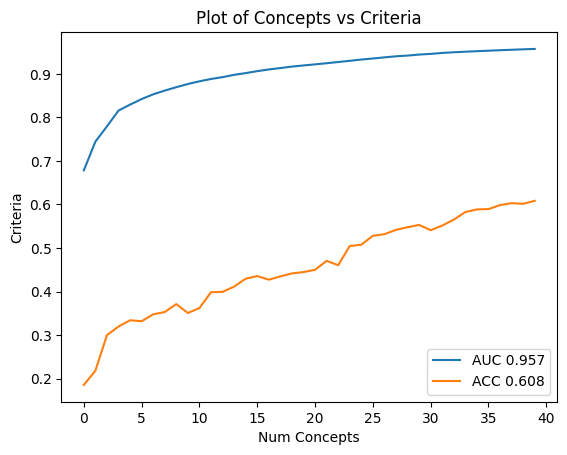

In [36]:
plt.plot(greedy_results["Score"], label = f"AUC {greedy_results['Score'].values[-1]:.3f}")
plt.plot(greedy_results["acc"], label = f"ACC {greedy_results['acc'].values[-1]:.3f}")

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')

plt.legend()
plt.show()


In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, ts_length, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, weights, save_model_path="/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", epochs=3000, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)


In [ ]:

plt.plot(model.val_losses)
plt.show()